# Manual Parameter Scan

In [17]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import hist
from hist import Hist
from rich.table import Table
from rich.console import Console

In [18]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.style.use(hep.style.CMS)

In [19]:
vector.register_awkward()

In [20]:
np.set_printoptions(suppress=True)

In [71]:
def inter_isolation(leptons_1, leptons_2, dR=1.6):
    """
    Compute the inter-isolation of each particle. It is supposed to work for one particle per event. The input is:
    - leptons_1: array of leptons for isolation calculation
    - leptons_2: array of all leptons in the events
    - dR: deltaR cut for isolation calculation
    """
    a, b = ak.unzip(ak.cartesian([leptons_1, leptons_2]))
    deltar_mask = a.deltaR(b) < dR
    return (ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

def muon_filter(events, nMuons=4):
    """
    Filter events after the TripleMu trigger.
    Cleans muons and electrons.
    Requires at least nMuons with mediumId, pt, dxy, dz, and eta cuts.
    """
    muons = events.Muon
    electrons = events.Electron
    clean_muons = (
        (events.Muon.mediumId)
        & (events.Muon.pt > 3)
        & (abs(events.Muon.dxy) <= 0.02)
        & (abs(events.Muon.dz) <= 0.1)
        & (abs(events.Muon.eta) < 2.4)
    )
    clean_electrons = (
        (events.Electron.mvaFall17V2noIso_WPL)
        & (events.Electron.pt > 3)
        & (
            abs(events.Electron.dxy)
            < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479)
        )
        & (
            abs(events.Electron.dz)
            < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479)
        )
        & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
        & (abs(events.Electron.eta) < 2.5)
    )
    muons = muons[clean_muons]
    electrons = electrons[clean_electrons]
    select_by_muons = ak.num(muons, axis=-1) >= nMuons
    events = events[select_by_muons]
    muons = muons[select_by_muons]
    electrons = electrons[select_by_muons]
    return events, electrons, muons

In [72]:
lumi = 59817.406
xsec_125 = 45.2

In [73]:
# Some commone paths
xrd_path = 'root://cmseos.fnal.gov//store/user/chpapage/SUEP_high_temp/2018/NANOAOD_merged/'
dataset = lambda mD, temp, decay: f"step_NANOAOD_mMed-125_mDark-{mD}_temp-{temp}_decay-{decay}_13TeV-pythia8.root"

In [74]:
decays = ['darkPho', 'darkPhoHad']
scan_points = [(2,8), (4,16), (8,8), (8,16), (8,32)]

In [80]:
cutflows = {}
pt_leading = []
pt_mean = []
h_i16 = []
for decay in decays:
    for mD, temp in scan_points:
        file = nanoevents.NanoEventsFactory.from_root(
            xrd_path + dataset(mD, temp, decay), 
            schemaclass=nanoevents.NanoAODSchema
        )
        events = file.events()
        name = f'mD-{mD}_T-{temp}_{decay}'
        print(f'Working on {name}')
        cutflows[name] = Hist.new.StrCategory(
            [
                'all',
                'trigger',  
                'nMu>=4', 
                'nMu>=6',
                'nMu>=4 & I16>1',
                'nMu>=4 & ptMu<10', 
                'nMu>=6 & ptMu<10', 
            ], 
            name='cutflow', 
            label='cutflow',
        ).Weight()
        n_total = len(events)
        scale = lumi * xsec_125 / n_total
        cutflows[name].fill(len(events) * ['all'], weight=scale)
        events = events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1]
        cutflows[name].fill(len(events) * ['trigger'], weight=scale)
        
        events, electrons, muons = muon_filter(events)
        muonsCollection = ak.zip(
            {
                "pt": muons.pt,
                "eta": muons.eta,
                "phi": muons.phi,
                "mass": muons.mass,
                "charge": muons.pdgId / (-13),
            },
            with_name="Momentum4D",
        )
        electronsCollection = ak.zip(
            {
                "pt": electrons.pt,
                "eta": electrons.eta,
                "phi": electrons.phi,
                "mass": electrons.mass,
                "charge": electrons.pdgId / (-11),
            },
            with_name="Momentum4D",
        )
        leptons = ak.concatenate([muonsCollection, electronsCollection], axis=-1)
        leading_muons = leptons[:, 0]
        i16 = inter_isolation(leading_muons, leptons)

        pt10_req = ak.all(muons.pt < 10, axis=-1)
        Muons_pt10 = muons[pt10_req]
        
        h = Hist.new.Regular(
            50, 
            2, 
            200, 
            transform=hist.axis.transform.log, 
            name=name, 
            label=name
        ).Double()
        h.fill(ak.fill_none(ak.pad_none(muons.pt, 2)[:,0], 0))
        pt_leading.append(h)
        
        h = Hist.new.Regular(
            50, 
            2, 
            200, 
            transform=hist.axis.transform.log, 
            name=name, 
            label=name
        ).Double()
        h.fill(ak.fill_none(ak.mean(muons.pt, axis=-1), 0))
        pt_mean.append(h)

        h = Hist.new.Regular(
            50, 
            0, 
            20,
            name=name, 
            label=name
        ).Double()
        h.fill(i16)
        h_i16.append(h)
        
        num_mu_4 = ak.num(muons) >= 4
        num_mu_6 = ak.num(muons) >= 6
        num_mu_pt10_4 = ak.num(Muons_pt10) >= 4
        num_mu_pt10_6 = ak.num(Muons_pt10) >= 6
        
        i64_mu4 = num_mu_4 & (i16 > 1)

        cutflows[name].fill(ak.sum(num_mu_4) * ['nMu>=4'], weight=scale)
        cutflows[name].fill(ak.sum(num_mu_6) * ['nMu>=6'], weight=scale)
        cutflows[name].fill(ak.sum(i64_mu4) * ['nMu>=4 & I16>1'], weight=scale)
        cutflows[name].fill(ak.sum(num_mu_pt10_4) * ['nMu>=4 & ptMu<10'], weight=scale)
        cutflows[name].fill(ak.sum(num_mu_pt10_6) * ['nMu>=6 & ptMu<10'], weight=scale)

Working on mD-2_T-8_darkPho
Working on mD-4_T-16_darkPho
Working on mD-8_T-8_darkPho
Working on mD-8_T-16_darkPho
Working on mD-8_T-32_darkPho
Working on mD-2_T-8_darkPhoHad
Working on mD-4_T-16_darkPhoHad
Working on mD-8_T-8_darkPhoHad
Working on mD-8_T-16_darkPhoHad
Working on mD-8_T-32_darkPhoHad


Text(0, 1, 'a.u.')

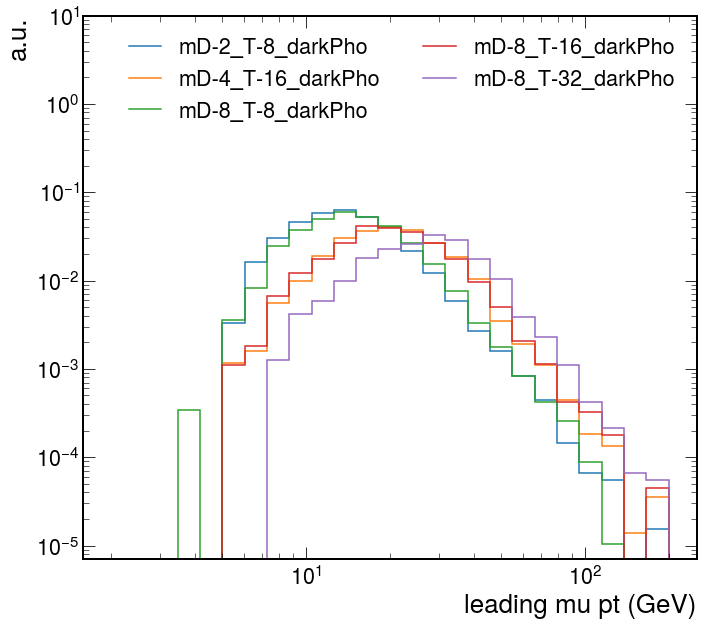

In [28]:
fig, ax = plt.subplots(figsize=(11, 10))
for h in pt_leading:
    if 'darkPhoHad' in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("leading mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

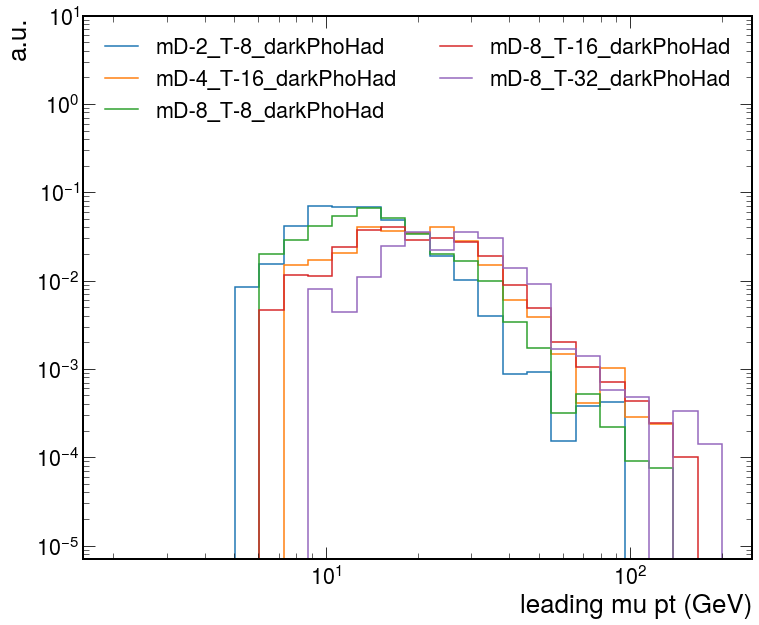

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in pt_leading:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("leading mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

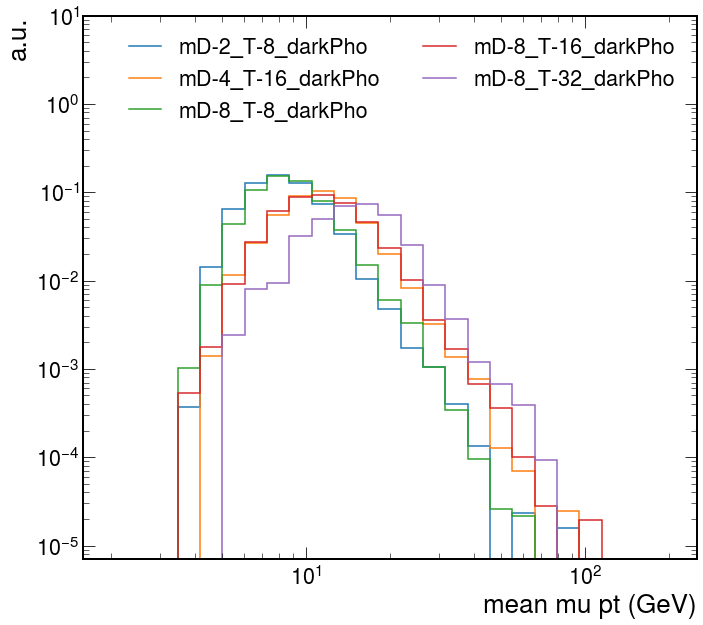

In [32]:
fig, ax = plt.subplots(figsize=(11, 10))
for h in pt_mean:
    if 'darkPhoHad' in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("mean mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

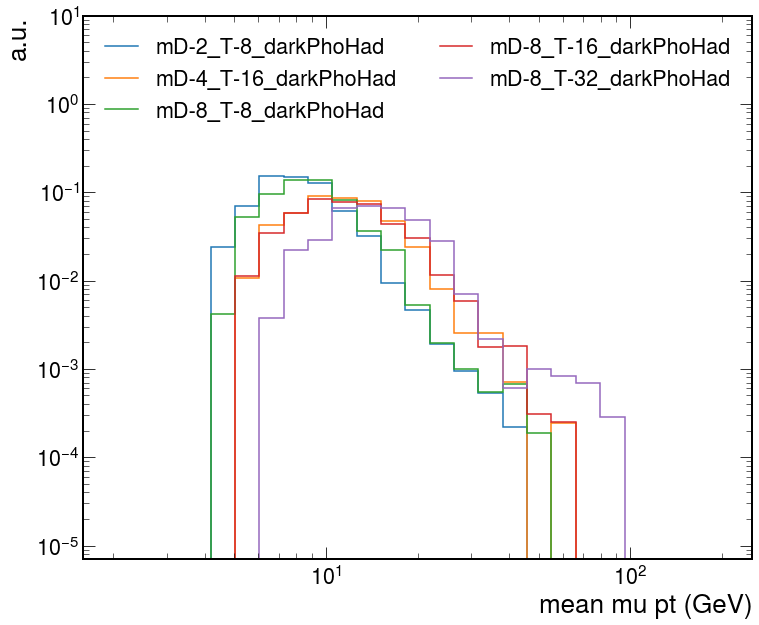

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in pt_mean:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("mean mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

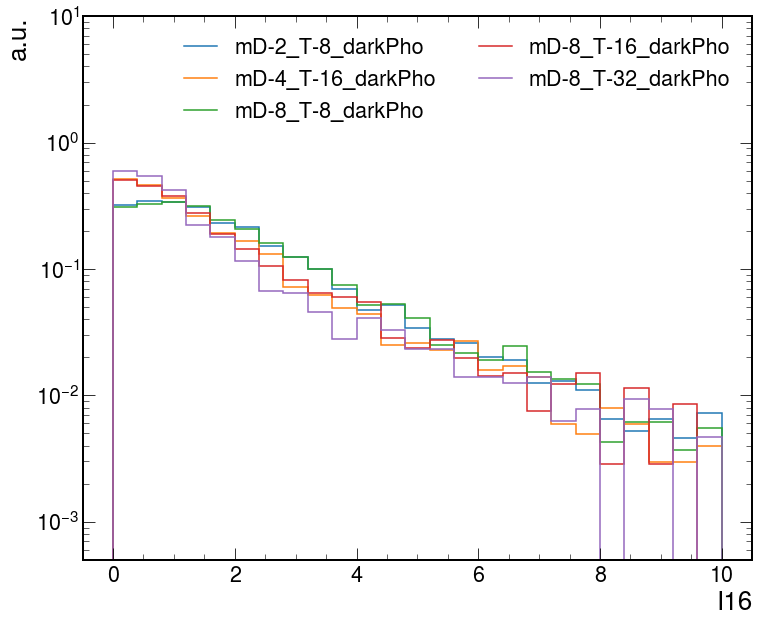

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in h_i16:
    if 'Had' in h.axes.label[0]:
        continue
    hep.histplot(h[:10j:1j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(5e-4, 1e1)
plt.yscale('log')
plt.xlabel("I16")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

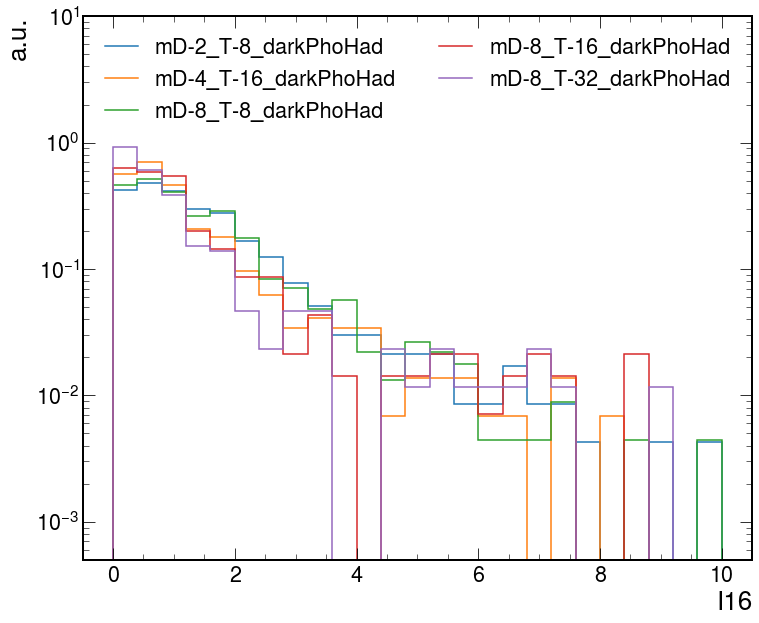

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in h_i16:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[:10j:1j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(5e-4, 1e1)
plt.yscale('log')
plt.xlabel("I16")
plt.ylabel("a.u.")

### Inter-isolation

In [41]:
events, muons, electrons = muon_filter(events)
muonsCollection = ak.zip(
    {
        "pt": muons.pt,
        "eta": muons.eta,
        "phi": muons.phi,
        "mass": muons.mass,
        "charge": muons.pdgId / (-13),
    },
    with_name="Momentum4D",
)
electronsCollection = ak.zip(
    {
        "pt": electrons.pt,
        "eta": electrons.eta,
        "phi": electrons.phi,
        "mass": electrons.mass,
        "charge": electrons.pdgId / (-11),
    },
    with_name="Momentum4D",
)
leptons = ak.concatenate([muonsCollection, electronsCollection], axis=-1)
leading_muons = leptons[:, 0]
i16 = inter_isolation(leading_muons, leptons)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3dca892250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

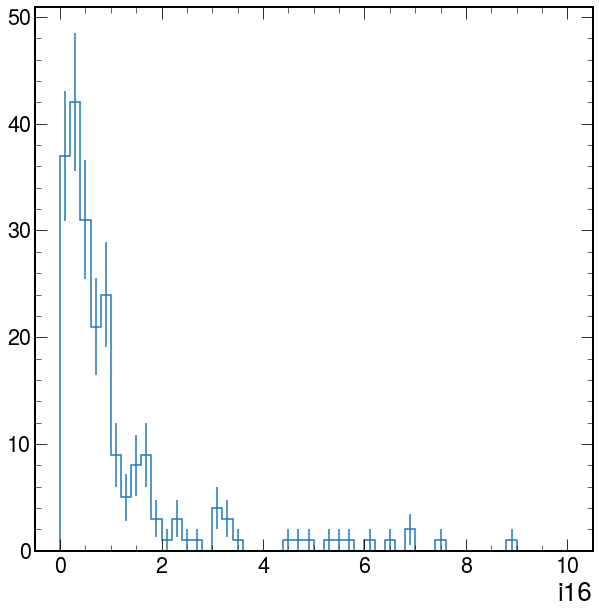

In [47]:
Hist.new.Reg(50, 0 ,10, name="i16", label="i16").Double().fill(i16).plot()

### Cutflow tables

In [51]:
cutflows['mD-8_T-32_darkPhoHad']

Hist(StrCategory(['all', 'trigger', 'nMuon >= 4', 'nMuon >= 6', 'nMuon >= 4 &\n pt_mu < 10', 'nMuon >= 6 &\n pt_mu < 10'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=2.83569e+06, variance=7.66699e+08)

In [52]:
list(range(4))

[0, 1, 2, 3]

In [81]:
table = Table(title="Cutflows")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

year='2018'
samples = []
for decay in decays:
    for mD, temp in scan_points:
        samples += [f'mD-{mD}_T-{temp}_{decay}',]

n=3
cols_to_show = [1, 2, 4]# list(range(n,n+3))
for i in cols_to_show:
    col_name = cutflows[samples[0]].axes[0].bin(i)
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

for sample in samples:
    string = []
    estring = []
    for i in range(cutflows[sample].size-1):
        s = f'{cutflows[sample][i].value:0.1f}'
        es = f'{math.sqrt(cutflows[sample][i].variance):0.1f}'
        if cutflows[sample][i].value > 1000:
            s = f'{cutflows[sample][i].value:0.1e}'
            es = f'{math.sqrt(cutflows[sample][i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample,
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show], 
    )

console = Console()
console.print(table)

                                          Cutflows                                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃        Sample        ┃       trigger        ┃        nMu>=4        ┃    nMu>=4 & I16>1    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│   mD-2_T-8_darkPho   │  1.1e+06 ± 1.8e+04   │  1.1e+06 ± 1.7e+04   │  7.4e+05 ± 1.4e+04   │
│  mD-4_T-16_darkPho   │  7.6e+05 ± 1.5e+04   │  7.2e+05 ± 1.4e+04   │  3.6e+05 ± 1.0e+04   │
│   mD-8_T-8_darkPho   │  1.2e+06 ± 1.8e+04   │  1.1e+06 ± 1.7e+04   │  7.6e+05 ± 1.4e+04   │
│  mD-8_T-16_darkPho   │  8.0e+05 ± 1.5e+04   │  7.5e+05 ± 1.5e+04   │  3.9e+05 ± 1.0e+04   │
│  mD-8_T-32_darkPho   │  5.0e+05 ± 1.2e+04   │  4.7e+05 ± 1.2e+04   │  1.7e+05 ± 7.1e+03   │
│ mD-2_T-8_darkPhoHad  │  2.0e+05 ± 7.4e+03   │  1.6e+05 ± 6.7e+03   │  8.7e+04 ± 4.9e+03   │
│ mD-4_T-16_darkPhoHad │  1.1e+05 ± 5.6e+03   │  1.0e+05 ± 5.3e+03   │  3.3e+04 ± 3.0e+03   │
│ mD-8_T-8_darkPhoHad  │  2.0e+05 ± 7.4e+03   │  1.6e+05 ± 6.7e+03   │  8.0e+04 ± 4.7e+03   │
│ mD-8_T-16_darkPhoHad │  1.1e+05 ± 5.4e+03   │  9.6e+04 ± 5.1e+03   │  3.4e+04 ± 3.0e+03   │
│ mD-8_T-32_darkPhoHad │  6.8e+04 ± 4.3e+03   │  5.8e+04 ± 4.0e+03   │  1.2e+04 ± 1.8e+03   │
└──────────────────────┴──────────────────────┴──────────────────────┴──────────────────────┘

In [74]:
test_collection = ak.pad_none(Muons, 4)

In [87]:
test_collection[0].pt > 3

<Array [True, True, True, None] type='4 * ?bool'>

In [78]:
highpt = ak.argsort(test_collection.pt, axis=1, ascending=False, stable=True)

In [79]:
highpt

<Array [[0, 1, 2, 3], [0, ... 4], [0, 1, 2, 3]] type='250 * var * ?int64'>

In [88]:
ak.where(test_collection.pt > 10, 1, 0)

<Array [[1, 1, 0, None], ... [1, 1, 1, 1]] type='250 * var * ?int64'>